In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [3]:
#help(stats.expon)
#help(np.random.random)

In [14]:
T_half = 3.052*60
print('T half = {}\n'.format(T_half))
tau = T_half / np.log(2)
print('tau = {}\n'.format(tau))
N = 1000
tot_time = 1000
print('Number of steps considered = {}\n'.format(tot_time))
Thallium = np.array([N for i in range(tot_time)])
Lead = np.zeros(tot_time)

def p(t):
    return np.exp(-t/tau)

def cum_p(t):
    return 1 - np.exp(-t/tau)

def ITM(z):
    return -tau*np.log(1-z)
    

T half = 183.12

tau = 264.186315887587

Number of steps considered = 1000



In [15]:
Thallium = np.array([N for i in range(tot_time)])
Lead = np.zeros(tot_time)

for i in range(tot_time-1):
    decays = 0
    for j in range(Thallium[i]):
        u1 = np.random.random()
        if u1 < cum_p(1):
            decays = decays + 1
        else:
            continue
            
    Thallium[i+1] = Thallium[i] - decays
    Lead[i+1] = Lead[i] + decays

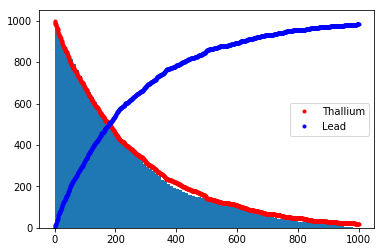

In [16]:
times = np.array([i for i in range(tot_time)])
ITM_times = ITM(np.random.random(1000))
plt.plot(times, Thallium, '.r', label = 'Thallium')
plt.plot(times, Lead, '.b', label = 'Lead')
plt.hist(ITM_times, range = (0,tot_time), bins = 100, cumulative = -1)
plt.legend()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

Condition b < C for scattering angle > $\frac{\pi}{2}$, with $C = \frac{Z e^2} {2\pi \epsilon_0 E }$

In [17]:
from scipy.stats import norm

In [32]:
# units expressed in 10^-14 m
C = 2.95
a0 = 5292
sigma = a0 / 100

def b(z):
    return sp.sqrt(-2*sigma**2 *sp.log(1-z))


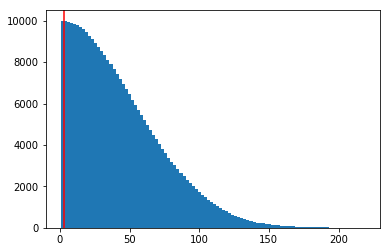

In [33]:
N = 10000
z = np.random.random(N)
bs = b(z)
plt.hist(bs, bins = 100, cumulative = -1)
plt.axvline(C, color = 'red')
plt.show()

In [38]:
back_scattered = bs[bs < C]
fraction = len(back_scattered)/N
print('Percentage of alpha particles back-scattered: {} %'.format(round(fraction*100,2)))

Percentage of alpha particles back-scattered: 1.8 %


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

In [11]:
def f(x):
    return sp.sin(1/(x*(x-2)))**2

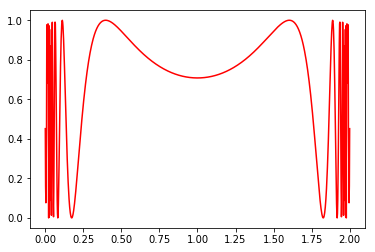

In [12]:
x=np.linspace(0.001,1.999,1000)
plt.plot(x,f(x),'r-')

In [13]:
# hit / miss method
N = 100000
count=0
for i in range(N):
    x=2*np.random.random()
    y=np.random.random()
    if y < f(x): 
        count+=1
I=2*count/N
print(I)

1.45134


In [14]:
# mean value method
# I_mean = (b-a)*<f>
b_a = 2
fs = f(2*np.random.random(N))
f_mean = fs.mean()
I_mean = b_a * f_mean
print(I_mean)

1.4505248141837437


In [15]:
help(np.random.random)

Help on built-in function random_sample:

random_sample(...) method of mtrand.RandomState instance
    random_sample(size=None)
    
    Return random floats in the half-open interval [0.0, 1.0).
    
    Results are from the "continuous uniform" distribution over the
    stated interval.  To sample :math:`Unif[a, b), b > a` multiply
    the output of `random_sample` by `(b-a)` and add `a`::
    
      (b - a) * random_sample() + a
    
    Parameters
    ----------
    size : int or tuple of ints, optional
        Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
        ``m * n * k`` samples are drawn.  Default is None, in which case a
        single value is returned.
    
    Returns
    -------
    out : float or ndarray of floats
        Array of random floats of shape `size` (unless ``size=None``, in which
        case a single float is returned).
    
    Examples
    --------
    >>> np.random.random_sample()
    0.47108547995356098
    >>> type(np.random.random_

In [16]:
def hit_miss_integral(func, a = 0, b = 1, M = 1, m = 0, N = 10000):
    count=0
    for i in range(N):
        # uniform distribution over [a,b)
        x=(b-a)*np.random.random() + a
        # uniform distribution over [0,h), M > max(f([a,b])), m < min(f([a,b])) (or equal)
        y= (M-m)*np.random.random() + m
        if y < f(x): 
            count+=1
    I=(b-a)*(M-m)*count/N # Area A = (b-a)*(M-m)
    return I

In [18]:
%timeit hit_miss_integral(f, b = 2)

43.6 ms ± 1.87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
print(hit_miss_integral(f, b = 2))

1.4444


In [19]:
def mean_value_integral(f, a = 0, b = 1, N = 10000):
    x = (b-a)*np.random.random(N) + a
    fs = f(x)
    f_mean = fs.mean()
    I_mean = (b-a) * f_mean
    return I_mean

In [20]:
print(mean_value_integral(f, b=2))

1.4426722748162886


In [23]:
for N in range(10000,100000, 10000):
    print('Result for N = {} : %.3f \n'.format(N) %mean_value_integral(f, b=2))

Result for N = 10000 : 1.450 

Result for N = 20000 : 1.447 

Result for N = 30000 : 1.451 

Result for N = 40000 : 1.464 

Result for N = 50000 : 1.456 

Result for N = 60000 : 1.451 

Result for N = 70000 : 1.453 

Result for N = 80000 : 1.448 

Result for N = 90000 : 1.455 



In [25]:
# much faster method!!
%timeit  mean_value_integral(f, b = 2)

322 µs ± 20.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [41]:
import math

def area(d = 2, N = 10000):
    # hit-miss method
    # consider a square [-1,1]x[-1,1] <=> consider 4 times the result of integration on [0,1]x[0,1]
    x = np.random.random((d,N))
    r_squared = np.zeros(N)
    for i in range(d):
        r_squared = r_squared + x[i]**2 
    mask = (r_squared < 1)
    r_squared = r_squared[mask]
    hits = len(r_squared)
    # the d-dimensional cube has always area (or volume) = 1
    I = hits/N * 2**d
    return I

In [48]:
print(area(d = 3))
print(4/3*math.pi)
print(area(d = 10))
# more dimensions => more data needed to estimate correctly the integral
print(area(d = 10, N = 10000000))

4.1184
4.1887902047863905
2.2528
2.5122816


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

In [100]:
def f1(x):
    return 1/(np.sqrt(x)*(np.exp(x) + 1))

def w(x):
    return 1/np.sqrt(x)

# f/w
def g(x):
    return 1/(np.exp(x) + 1)

In [109]:
N = 1000000
# no importance sampling
I = mean_value_integral(f1, a = 0, b = 1, N = N)
print(I)

0.8388033086919968


In [110]:
# importance sampling
def importance_sampling_integral(func, weight, a = 0, b = 1, N = 10000):
    x = (b-a)*np.random.random(N) + a
    g = func(x)/weight(x)
    g_mean = g.mean()
    print('f/w mean : ', g_mean)
    mv_int = mean_value_integral(weight, a = 0, b = 1, N = N)
    I_mean = g_mean * mv_int
    print('Integral of w between a and b : ', mv_int)
    return I_mean

In [111]:
N = 1000000
# with importance sampling
I1 = importance_sampling_integral(f1, w, a = 0, b = 1, N = N)
print(I1)

f/w mean :  0.37994662420610864
Integral of w between a and b :  2.002805646137922
0.7609592441910376


In [116]:
def w_uniform(x):
    return x/x

In [117]:
N = 1000000
# with importance sampling
I1 = importance_sampling_integral(f1, w_uniform, a = 0, b = 1, N = N)
print(I1)

f/w mean :  0.8401791416456407
Integral of w between a and b :  1.0
0.8401791416456407
